In [1]:
import keras
from keras.models import Sequential
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import  BatchNormalization
from keras.layers.convolutional import *
import numpy as np
import tensorflow as tf
# import theano
import  matplotlib.pyplot as plt
from PIL import Image
import matplotlib
import itertools
from numpy import*
from sklearn.utils import shuffle
%matplotlib inline
import random as rn
import os
os.environ['PYTHONASHSEED']= '0'

Using TensorFlow backend.


In [2]:
#import theano 
# import os
# os.environ['KERAS_BACKEND'] = 'theano'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN, device=gpu0, floatX=float32, optimizer=fast_compile'


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18023564142310782691
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 6735474197
locality {
  bus_id: 1
}
incarnation: 785691897751244546
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0"
]


In [4]:
#setting  the  seed for nummy_gennerated random numbers
np.random.seed(10)
#seting the seed for python random numbers
rn.seed(100)
#seting the seed for tensorflow random numbers
tf.set_random_seed(500)

In [5]:
train_path = 'D:\CASIA_DATASET\CASIA1\Train' 
valid_path = 'D:\CASIA_DATASET\CASIA1\Valid' 
test_path = 'D:\CASIA_DATASET\CASIA1\Test' 


In [6]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (224,224), classes = ['Au','Sp'], batch_size =10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size = (224,224), classes = ['Au','Sp'], batch_size = 10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (224,224), classes = ['Au','Sp'], batch_size =10)

Found 1201 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [7]:
# plots images with labels  within jupyter notebook

def plots(ims, figsize = (12,6), rows=1, interp =False , titles = None):
    if  type(ims[0]) is  np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] !=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize) 
    cols = len(ims)// rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')
        plt.show()
        

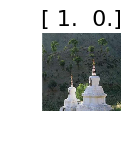

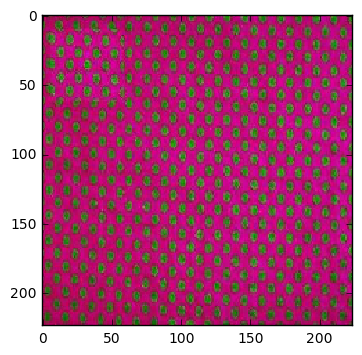

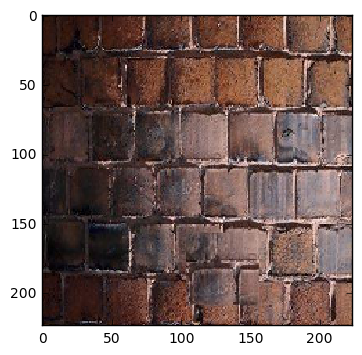

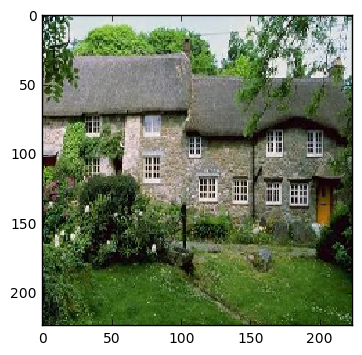

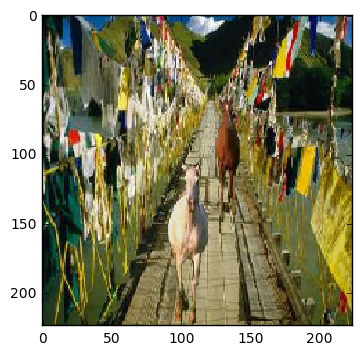

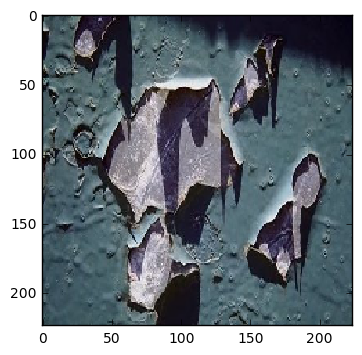

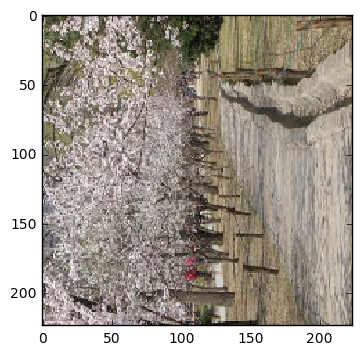

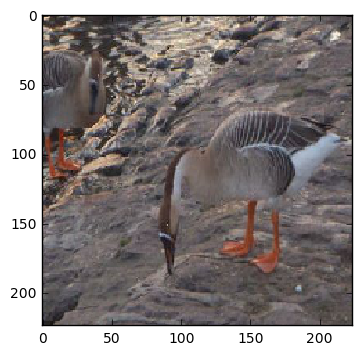

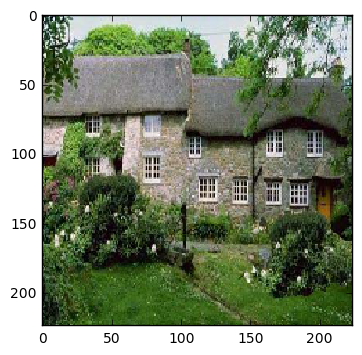

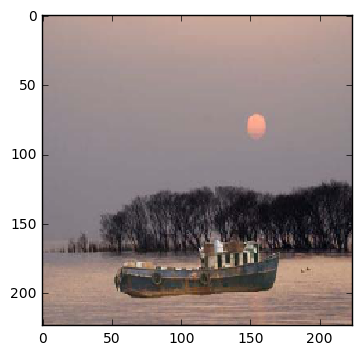

In [8]:
imgs, labels = next(train_batches)
plots(imgs, titles = labels)

In [9]:
######### fine_tune vgg_face 
def convblock(cdim, nb, bits=3):
    L = []
    
    for k in range(1,bits+1):
        convname = 'conv'+str(nb)+'_'+str(k)
        #L.append( Convolution2D(cdim, 3, 3, border_mode='same', activation='relu', name=convname) ) # Keras 1
        L.append( Convolution2D(cdim, kernel_size=(3, 3), padding='same', activation='relu', name=convname) ) # Keras 2
    
    L.append( MaxPooling2D((2, 2), strides=(2, 2)) )
    
    return L

In [10]:
def vgg_face_blank():
    
    withDO = True # no effect during evaluation but usefull for fine-tuning
    
    if True:
        mdl = Sequential()
        
        # First layer is a dummy-permutation = Identity to specify input shape
        mdl.add( Permute((1,2,3), input_shape=(224,224,3)) ) # WARNING : 0 is the sample dim

        for l in convblock(64, 1, bits=2):
            mdl.add(l)

        for l in convblock(128, 2, bits=2):
            mdl.add(l)
        
        for l in convblock(256, 3, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 4, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 5, bits=3):
            mdl.add(l)
        
        #mdl.add( Convolution2D(4096, 7, 7, activation='relu', name='fc6') ) # Keras 1
        mdl.add( Convolution2D(4096, kernel_size=(7, 7), activation='relu', name='fc6') ) # Keras 2
        if withDO:
            mdl.add( Dropout(0.5) )
        #mdl.add( Convolution2D(4096, 1, 1, activation='relu', name='fc7') ) # Keras 1
        mdl.add( Convolution2D(4096, kernel_size=(1, 1), activation='relu', name='fc7') ) # Keras 2
        if withDO:
            mdl.add( Dropout(0.5) )
        #mdl.add( Convolution2D(2622, 1, 1, name='fc8') ) # Keras 1
        mdl.add( Convolution2D(2622, kernel_size=(1, 1), activation='relu', name='fc8') ) # Keras 2
        mdl.add( Flatten() )
        mdl.add( Activation('softmax') )
        
        return mdl
    
    else:
        # See following link for a version based on Keras functional API :
        # gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9
        raise ValueError('not implemented')

In [11]:
facemodel = vgg_face_blank()

In [12]:
# facemodel.summary()

In [13]:
model = Sequential()
for layer in facemodel.layers:
    model.add(layer)

In [14]:
## remove  last layer  of  vgg_face 
model.layers.pop() 
# model.summary()

In [15]:
### add SVM in the  last layer
from keras import regularizers
model.add(Dense(2, activation = 'linear', kernel_regularizer=regularizers.l2(0.001)))

#### set trainable layer  
for layer in model.layers:
    layer.trainable = True

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

In [16]:
#for layer in model.layers:
#    layer.trainable = False
##### compile with SGD
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='hinge', optimizer=sgd, metrics=['accuracy'])

##### compile with Adam 
# opt = Adam(lr=0.0001, decay=10e-6)
# model.compile(loss='hinge', optimizer=opt, metrics=['accuracy'])

# model.compile(loss='hinge', optimizer='adadelta', metrics=['accuracy'])

In [ ]:
### training    
from keras.callbacks import ModelCheckpoint
# Save check point
filepath = "vggface.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose =1, save_best_only = True, mode ='max')
callbacks_list= [checkpoint]
 # Fit the model
# model.fit(X,Y, validation_split=0.33, nb_epoch =150, batch_size =10, callbacks = callbacks_list, verbose =0)

history = model.fit_generator(train_batches, steps_per_epoch = 120, validation_data = valid_batches, validation_steps=26, epochs =500, shuffle=True, callbacks = callbacks_list, verbose =2)

Epoch 1/500


In [ ]:
# plot history 
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc= 'upper left' )
plt.show()